In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from helpers import *
from Sampler import Sampler
from tqdm import tqdm


def analyse_output_bitstrings(sampler, repeats = 100, title = "Transition Matrix", plot_grid = False, plot_cumulative = False):
    """
    Analyzes the output bitstrings generated by a sampler and computes various metrics 
    related to transition probabilities, BD transitions, and forbidden/self transitions. 
    Optionally, it visualizes the transition matrix and cumulative probability distributions.
    Parameters:
    -----------
    sampler : object
        The sampler object that generates proposals and contains relevant parameters 
        such as `n` (number of nodes) and `q` (number of bits in the bitstring).
    repeats : int, optional
        The number of times to repeat the sampling process for each configuration. 
        Default is 100.
    title : str, optional
        The title for the transition matrix plot. Default is "Transition Matrix".
    plot_grid : bool, optional
        If True, displays the transition matrix plot. If False, the plot is closed. 
        Default is False.
    plot_cumulative : bool, optional
        If True, displays the cumulative probability histogram. If False, the plot is closed. 
        Default is False.
    Returns:
    --------
    weighted_BD_transitions_ignoring_self_transitions : numpy.ndarray
        A flattened array of weighted BD transitions, excluding self-transitions, 
        used for cumulative probability analysis.
    Notes:
    ------
    - The function computes the transition matrix, BD action differences, and 
        forbidden/self transition frequencies.
    - The function supports visualization of the transition matrix and cumulative 
        probability distributions.
    - Forbidden transitions are transitions to configurations that are not valid 
        causal matrices.
    - Self-transitions are transitions where the initial and proposed configurations 
        are the same.
    """
    
    if repeats ==1:
        raise ValueError("Repeats must be greater than 1")
    
    # Generate all of the possibl causal matrices for cardinality n
    _, unique_causal_matrix = get_unique_matrices(sampler.n)
    
    
    # Generate the binary matrix
    mats = [np.frombuffer(mat, dtype=np.int32).reshape( sampler.n,  sampler.n) for mat in  unique_causal_matrix]
    
    print(" ")
    print("Number of unique causal matrices: ", len(mats))
    
    # For each matrix, generate a bitstring
    labels = ["".join(str(i) for i in mat[np.triu_indices( sampler.n, 1)]) for mat in mats]
    
    # Create an array that hold the number of proposals from each causal matrix to each other matrix
    proposal_tracker = np.zeros((2** sampler.q,2** sampler.q))
    
    # Create an array that holds the BD action values for each causal matrix
    BD_action = np.zeros(2** sampler.q)
    
    # Loop through each causal matrix, and create example proposals. 
    # This gives an indication of what binary matrices are proposed from each causal matrix
    for s_pos, s in tqdm(enumerate(labels)):
        
        
        s_prime_list =  sampler.proposal(s, multiple = repeats)
        s_int = int(s, 2)
        
        for s_prime in s_prime_list:
            s_prime_int = int(s_prime, 2)
            proposal_tracker[s_int, s_prime_int] += 1


        BD_action[s_int] =  calculate_action(mats[s_pos])
    
    
    
    BD_sorted_args = np.argsort(BD_action)
    sorted_BD = BD_action[BD_sorted_args]
    # Sort the proposal tracker according to BD action,
    proposal_tracker = proposal_tracker[BD_sorted_args,:]
    proposal_tracker = proposal_tracker[:,BD_sorted_args]
    
    #reorder and normalise
    _proposal_tracker = np.flipud(proposal_tracker)/repeats
    

    cmap = colors.LinearSegmentedColormap.from_list('red_white', ['white', 'red'], N=256)
    
    
    non_zero_bd_index = np.where(sorted_BD != 0)[0][0]
    plt.xticks([])
    plt.yticks([])
    plt.ylim(non_zero_bd_index, 2** sampler.q)
    plt.imshow(_proposal_tracker, extent=[0, 2**sampler.q, 0, 2**sampler.q], cmap=cmap, interpolation='nearest', norm=colors.LogNorm(vmin=1/(2*repeats), vmax=1))
    plt.colorbar(label='Transition Probability', norm=colors.LogNorm(vmin=1/repeats, vmax=1))
    plt.xlabel('Proposed Configuration (s\')')
    plt.ylabel('Initial Configuration (s)')
    plt.title(title)
    
    
    s_int_list = [int(s, 2) for s in labels]
    all_ints = np.arange(0, 2** sampler.q)
    

    all_ints = all_ints[BD_sorted_args]
    
    plt.plot([non_zero_bd_index, 2** sampler.q], [non_zero_bd_index,non_zero_bd_index] ,color='blue', linestyle='--', label='Non-zero BD')
    plt.plot([non_zero_bd_index,non_zero_bd_index], [non_zero_bd_index, 2**sampler.q] ,color='blue', linestyle='--', label='Non-zero BD')


    
    forbidden_count = 0
    for s_pos, s_int in enumerate(all_ints):
        if s_int not in s_int_list:
            for pos_i, i in enumerate(all_ints):
                if proposal_tracker[pos_i, s_pos] > 0:
                    forbidden_count += proposal_tracker[pos_i, s_pos]

            
    print(" ")
    print(" --------------------- ")
    print(title)
    BD_transitions = np.zeros((2** sampler.q,2** sampler.q))
    for i in range(2** sampler.q):
        for j in range(2** sampler.q):
            BD_transitions[i,j] = np.abs(sorted_BD[i] - sorted_BD[j])
    
    total_bd_transition_cost = np.sum((BD_transitions[non_zero_bd_index:,non_zero_bd_index:] * proposal_tracker[non_zero_bd_index:,non_zero_bd_index:]))
    
    total_transitions = np.sum(proposal_tracker)
    
    self_transitions = np.sum(np.diag(proposal_tracker))
    
    Average_BD_transition_cost = total_bd_transition_cost/(total_transitions-forbidden_count-self_transitions)
    frequency_self_transitions = self_transitions/total_transitions
    frequency_forbidden_transitions = forbidden_count/total_transitions
    print(" ")
    print("Average BD transition cost (ignoring forbidden and self transitions): ", Average_BD_transition_cost)
    print(" ")
    print("Frequency of self transitions: ", frequency_self_transitions)
    print("Frequency of forbidden transitions: ", frequency_forbidden_transitions)
    
    if plot_grid:
        plt.show()
    else:
        plt.close()

    
    print(" --------------------- ")
    print(" ")
    
    return Average_BD_transition_cost, frequency_self_transitions, frequency_forbidden_transitions
    
    

/mnt/c/Users/Stuart Ferguson/OneDrive - University of Edinburgh/Documents/PhD/CODE/CST/SamplingCausalSets/SamplingCausalSets/.venv/lib/python3.13/site-packages/numpy/_core/getlimits.py:552: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [9]:
# Cardinality of causal set that we are interested in
cardinality = 4

# Number of times to repeat the sampling process per input causal set
repeats = 10000

t = 20

cargs recieved :  {'link_move': True, 'relation_move': True}
------------------------------------------------------------
Starting classical algorithm with the following parameters:
Link move:  True
Relation move:  True


 ... (more hidden) ...

Time taken:  0.19818949699401855  (per step:  0.00018000862578929932 , per sample  0.0019818949699401856 )
acceptance rate:  0.7547683923705722
self move rate:  0.24432334241598547
Using  5  qubits out of  6
------------------------------------------------------------
Starting quantum algorithm with the following parameters:
gamma_TC:  0.99
gamma_BD:  0
gamma_mixing:  0.01
t:  20


 
Number of unique causal matrices:  40


 ... (more hidden) ...


 
 --------------------- 
5
 
Average BD transition cost (ignoring forbidden and self transitions):  0.035350207845740035
 
Frequency of self transitions:  0.8565425
Frequency of forbidden transitions:  0.0003225


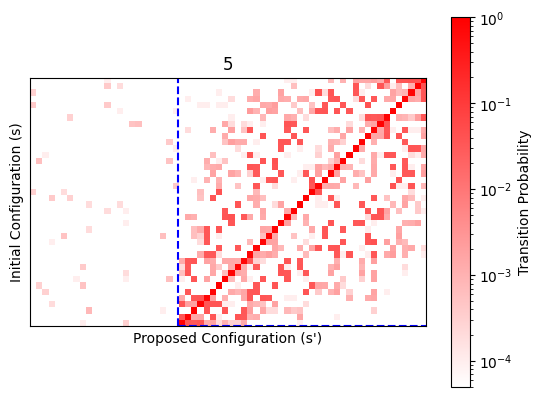

 --------------------- 
 


In [10]:

Csamp = Sampler(cardinality, method="classical",dimension = 4, cargs = {"link_move": True, "relation_move": True})
Csamp.sample_uniform(num_samples = 100, sample_frequency = 10, T_therm = 100)
for num_qubits in [5,]:
    Qsamp = Sampler(cardinality, method="quantum",dimension = 4, qargs = {"gammas":[0.99, 0, 0.01], "t":t, "num_qubits": num_qubits, })
    #Qsamp.analyse_TC_Hamiltonian(num_qubits)
    BD_trans_cost, self_trans, forbdden_trans = analyse_output_bitstrings(Qsamp, repeats = repeats, title = str(num_qubits), plot_grid = True, plot_cumulative = False)
    #Qsamp.sample_uniform(num_samples = 100, sample_frequency = 10, T_therm = 100)
